# CS145: Project 3 | Analysis of factors affecting California population change and prediction of future trends

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Heyaojing Huang, hhyj4495*
* *Yuer Zhou, zye98*

## Project Overview

---

California is the most populated U.S. state, with an estimated population of 39.512 million as of July 1, 2019[1]. However, from 2010 to now, California is experiencing its slowest population growth rates. It is the consequence of fewer births, more deaths, a slowing of international migration, and—capturing a great deal of attention—a large migration out of California to other states[2].

In this context, we began to consider from 2010 to 2018, what factors affect migration and population change in California? For all the counties in California, how do their population change trends differ? In this project, we will consider the impact of income, age, educational attainment and race on population change. Moreover, based on existing data, we will make predictions on population change trends in the next year.

reference:

*   [1]https://en.wikipedia.org/wiki/Demographics_of_California
*   [2]https://www.ppic.org/blog/whos-leaving-california-and-whos-moving-in/

To approach these questiosn, we will first tackle the following supplementary questions in order to understand the overall trends of California's population change and determine the best way to predict future trends:

1.   How does the total population in California change from 2010-2018? What is the population growth rate in every year?
2.   From 2010-2018, which counties have the largest population growth? Which counties have the least (or negative) population growth?
3.   From 2010-2018, what is the distribution of population growth in California? What percentage of counties have higher population growth? What percentage of counties have lower population growth?
4.   What has changed in the demographic composition of the counties in ​California from 2010-2018? What factors have the most impact on population change? We will break down by each factor: 
  *   Income
  *   Age
  *   Educational attainment
  *   House rent
  *   Employment
  *   Race
  *   Family households rate

5.   How to construct the input features and output label of the ML model? Which model can predict the population change trend of the next year more accurately?

---


## Analysis of Dataset


### ****Dataset Overview****


**(1) Census_bureau_acs (Census Bureau American Community Survey)**
- Dataset ID: bigquery-public-data:census_bureau_acs
  - [ZIP level]
`bigquery-public-data:census_bureau_acs.zip_codes_20xx_5yr` (from 2011 to 2018) ~= 62MB * 8
= 496MB

  - [county level]
`bigquery-public-data:census_bureau_acs.county_20xx_1yr` (from 2011 to 2018) ~= 1.5MB * 8 
= 12MB

- Purpose of using the dataset

    This dataset provide information about American Community Survey. We choose 2 types of tables from the dataset, and ​​these 2 types of tables collect data from 2 different geographic granularities: zip code level and county level. The specific information provided includes: household structure, percentage of income that is spent on rent, age, race, income, education attainment, commutes time per day, gender, employment, language spoken…
    These factors may have affected the population change to a certain extent. We use this dataset as the main source of information for this project.
- Table schema
  - primary key: `geo_id`

**(2) Census Bureau US Boundaries**
- Dataset ID: bigquery-public-data:geo_us_boundaries
  - `bigquery-public-data:geo_us_boundaries.zip_codes` ~= 1.19 GB

  - `bigquery-public-data:geo_us_boundaries.urban_areas` ~= 194.24 MB

- Purpose of using the dataset

    - The table `zip_codes` provides the geographic coordinates, range, latitude and longitude of the area represented by each zip code. Also, it provides information about the county and state of the region represented by the zip code. This table is very important, becasue it can link information on different geographic granularities together.
    - The table `urban_areas` tells us whether an area is an urban area, and is used to study whether population change is related to urbanization.

- Table schema
  - `urban_areas` primary key: `geo_id`
  - `zip_codes` primary key: `zip_code`





## Data Exploration

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-project3-331000"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

---

PART 1 

---


How has the total population in California changed in the past 8 years? 

Which areas have negative/positive population growth? 

What is the proportion of regions with negative/positive growth? 

(Block group level / zip code level / County level)

---

In [ ]:
%%bigquery --project $project_id total_pop_county

SELECT 
    do_date,counties.geo_id,counties.county_name,total_pop
FROM (
    SELECT  
        do_date,total_pop,geo_id
    FROM  `bigquery-public-data.census_bureau_acs.county_2011_1yr` Y2011
    union all
    SELECT 
        do_date,total_pop,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2012_1yr` Y2012
    union all
    SELECT 
        do_date,total_pop,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2013_1yr` Y2013
    union all
    SELECT 
        do_date,total_pop,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2014_1yr` Y2014
    union all
    SELECT 
        do_date,total_pop,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2015_1yr` Y2015
    union all
    SELECT 
        do_date,total_pop,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2016_1yr` Y2016
    union all
    SELECT  
        do_date,total_pop,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2017_1yr` Y2017
    union all
    SELECT 
        do_date,total_pop,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2018_1yr` Y2018
    ) Y2011_2018,
    `bigquery-public-data.geo_us_boundaries.counties` counties
WHERE counties.geo_id = Y2011_2018.geo_id
AND counties.state_fips_code = "06"
ORDER BY do_date

We save the above view as `cs145-project3-331000.population_change.all_counties`

In [ ]:
%%bigquery --project $project_id cal_total_pop

SELECT do_date,sum(total_pop) AS total_pop_cal
FROM `cs145-project3-331000.population_change.all_counties`
WHERE total_pop IS NOT NULL
GROUP BY do_date
ORDER BY do_date

Text(0, 0.5, 'total population')

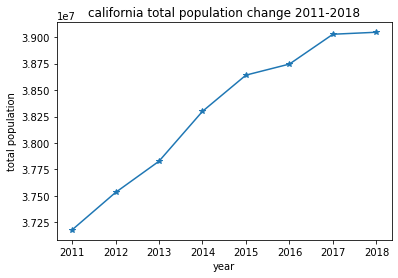

In [ ]:
x = cal_total_pop["do_date"]
y = cal_total_pop["total_pop_cal"]
plt.plot(x, y, marker='*',label = "california total population")
plt.title("california total population change 2011-2018")
plt.xlabel("year")
plt.ylabel("total population")

As is shown in the above chart, from 2011 to 2018, the total population of California showed a continuous upward trend. However, it is clear that the rate of increase was decreasing.

In [ ]:
%%bigquery --project $project_id cal_pop_growth_rate

SELECT t1.do_date,
    ROUND(t1.total_pop_cal/t2.total_pop_cal-1, 4) AS total_pop_growth_rate
FROM 
     (
    SELECT do_date,sum(total_pop) AS total_pop_cal
    FROM `cs145-project3-331000.population_change.all_counties`
    WHERE total_pop IS NOT NULL
    GROUP BY do_date
    ORDER BY do_date) t1, 
     (
    SELECT do_date,sum(total_pop) AS total_pop_cal
    FROM `cs145-project3-331000.population_change.all_counties`
    WHERE total_pop IS NOT NULL
    GROUP BY do_date
    ORDER BY do_date) t2 
WHERE CAST(t1.do_date AS INT) = CAST(t2.do_date AS INT) + 1
ORDER BY t1.do_date

Text(0, 0.5, 'population growth rate')

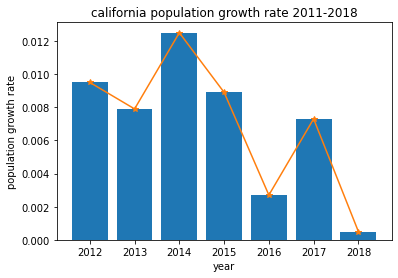

In [ ]:
plt.figure()
labels = cal_pop_growth_rate["do_date"]
total_pop_growth_rate = cal_pop_growth_rate["total_pop_growth_rate"]

plt.bar(labels, total_pop_growth_rate)
plt.plot(labels, total_pop_growth_rate,c='#ff7f0e',marker='*')
plt.title("california population growth rate 2011-2018")
plt.xlabel("year")
plt.ylabel("population growth rate")

As shown above, California's total population growth rate fluctuated over 8 years. Overall, the growth rate was largest in 2014,exceeding 1.2%, and has continued to decline since then (except for 2017), and reached the minimum in 2018.

Then, we are going to analyze the population mobility characteristics of each county in California. In order to find out a more typical and representative conclusion, we will mainly focus on the study of the population distribution characteristics of TOP 5 counties with the largest and smallest population changes.

In [ ]:
%%bigquery --project $project_id positive_pop_change_state

SELECT 
    counties.county_name, 
    counties.geo_id,
    (countyPop.pop_2018 - countyPop.pop_2011) AS net_pop_change,
    int_point_geom
FROM 
    `bigquery-public-data.geo_us_boundaries.counties` counties,
    `cs145-project3-331000.population_change.population_change_county` countyPop
WHERE 
    counties.geo_id = countyPop.geo_id
ORDER BY net_pop_change DESC
LIMIT 5

Text(0, 0.5, 'county name')

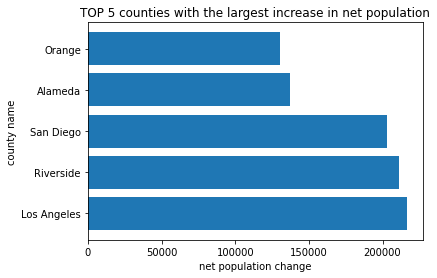

In [ ]:
plt.figure()

plt.barh(positive_pop_change_state["county_name"], positive_pop_change_state["net_pop_change"])
plt.title("TOP 5 counties with the largest increase in net population")
plt.xlabel("net population change")
plt.ylabel("county name")

From the above bar chart, we can figure out that in the past 8 years, the TOP 5 counties with the largest net population growth in California are Los Angeles, Riverside, San Diego, Alameda, Orange, respectively.

In [ ]:
%%bigquery --project $project_id negative_or_low_increase_pop_change_state

SELECT 
    counties.county_name, 
    counties.geo_id,
    (countyPop.pop_2018 - countyPop.pop_2011) AS net_pop_change,
    int_point_geom
FROM 
    `bigquery-public-data.geo_us_boundaries.counties` counties,
    `cs145-project3-331000.population_change.population_change_county` countyPop
WHERE 
    counties.geo_id = countyPop.geo_id
ORDER BY net_pop_change
LIMIT 5

Text(0, 0.5, 'county name')

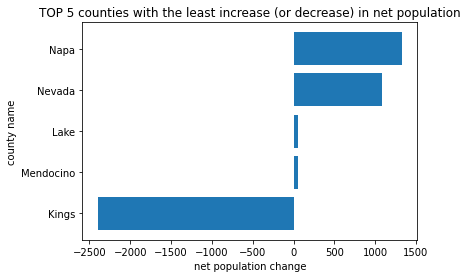

In [ ]:
plt.figure()

plt.barh(negative_or_low_increase_pop_change_state["county_name"], negative_or_low_increase_pop_change_state["net_pop_change"])
plt.title("TOP 5 counties with the least increase (or decrease) in net population")
plt.xlabel("net population change")
plt.ylabel("county name")

The TOP 5 counties with the least net population growth in California are Kings, Mendocino, Lake, Nevada, Napa, respectively. 
Among them, Kings had a negative population growth of nearly 2500 people.

Meanwhile, we stepped deeper into analyzing the overall population change in all counties by setting different thresholds(0, 2000, 4000, 6000, 8000, 10000)

In [ ]:
%%bigquery --project $project_id pop_change_distribution
SELECT 
    COUNTIF(net_pop_change<0) AS pop_change_less_0, 
    COUNTIF(net_pop_change BETWEEN 0 AND 20000) AS pop_change_0_20000, 
    COUNTIF(net_pop_change BETWEEN 20000 AND 40000) AS pop_change_20000_40000, 
    COUNTIF(net_pop_change BETWEEN 40000 AND 60000) AS pop_change_40000_60000, 
    COUNTIF(net_pop_change BETWEEN 60000 AND 80000) AS pop_change_60000_80000,
    COUNTIF(net_pop_change BETWEEN 80000 AND 100000) AS pop_change_80000_100000,
    COUNTIF(net_pop_change > 100000) AS pop_change_greater_100000
FROM(
    SELECT 
        counties.county_name, 
        counties.geo_id,
        (countyPop.pop_2018 - countyPop.pop_2011) AS net_pop_change,
        int_point_geom
    FROM 
        `bigquery-public-data.geo_us_boundaries.counties` counties,
        `cs145-project3-331000.population_change.population_change_county` countyPop
    WHERE 
        counties.geo_id = countyPop.geo_id)

([<matplotlib.patches.Wedge at 0x7fbe1f9f8c50>,
 [Text(-0.0863050065840288, 1.0966090670054351, 'pop_change_less_0'),
  Text(-1.046162154398837, -0.33991873544066975, 'pop_change_0_20000'),
  Text(0.714392925603445, -0.8364465002902164, 'pop_change_20000_40000'),
  Text(1.04616220213706, -0.33991858851751156, 'pop_change_40000_60000'),
  Text(1.096609057914914, 0.08630512208997297, 'pop_change_60000_80000'),
  Text(1.0696068844881415, 0.25679001665869294, 'pop_change_80000_100000'),
  Text(0.6465636712884596, 0.8899187709954145, 'pop_change_greater_100000')],
 [Text(-0.04707545813674298, 0.5981504001847827, '2.5%'),
  Text(-0.5706339023993656, -0.1854102193312744, '55.0%'),
  Text(0.38966886851097, -0.4562435456128452, '7.5%'),
  Text(0.5706339284383963, -0.18541013919136992, '10.0%'),
  Text(0.5981503952263166, 0.04707552113998525, '2.5%'),
  Text(0.5834219369935316, 0.1400672818138325, '2.5%'),
  Text(0.3526710934300688, 0.4854102387247715, '20.0%')])

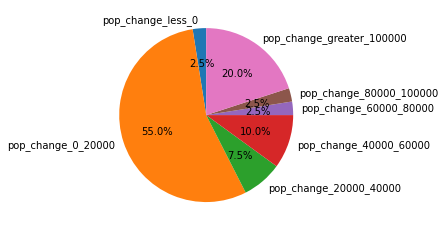

In [ ]:
labels = ["pop_change_less_0",	"pop_change_0_20000",	"pop_change_20000_40000",
          "pop_change_40000_60000",	"pop_change_60000_80000",	"pop_change_80000_100000", "pop_change_greater_100000"]
plt.pie(pop_change_distribution[0:1], labels=labels, autopct='%1.1f%%',startangle=90)

The results show that, in the past 8 years, most of the counties(more than half) have had population growth between 0-20000 people, 20 percent of the counties' population growth exceeded 100,000 people, and only 2.5 percent of the counties show negative growth.

---

PART 2 

---


What has changed in the demographic composition of each area of ​​California in the past X years? (Break down by each factor)

Age / Race / Education attainment / Income/ House rent/ Employment


(1) demographic composition -- income analysis

We focus on the TOP2 counties with the most increase in population (Los Angeles, Riverside) and the TOP2 counties with the least increase (or decrease) in population(Kings, Mendocino). We set two thresholds for income, below 39,999 are low-income households, 40,000-99,999 are middle-income households, and more than 100,000 are high-income households.

In [ ]:
%%bigquery --project $project_id factor_income

SELECT 
    do_date, counties.geo_id, income_less_10000, income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,
    income_30000_34999,income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
    income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more
FROM (
    SELECT  
        do_date,income_less_10000,income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,income_30000_34999,
        income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
        income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more,geo_id
    FROM  `bigquery-public-data.census_bureau_acs.county_2011_1yr` Y2011
    union all
    SELECT 
        do_date,income_less_10000,income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,income_30000_34999,
        income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
        income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2012_1yr` Y2012
    union all
    SELECT 
        do_date,income_less_10000,income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,income_30000_34999,
        income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
        income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2013_1yr` Y2013
    union all
    SELECT 
        do_date,income_less_10000,income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,income_30000_34999,
        income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
        income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2014_1yr` Y2014
    union all
    SELECT 
        do_date,income_less_10000,income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,income_30000_34999,
        income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
        income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2015_1yr` Y2015
    union all
    SELECT 
        do_date,income_less_10000,income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,income_30000_34999,
        income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
        income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2016_1yr` Y2016
    union all
    SELECT  
        do_date,income_less_10000,income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,income_30000_34999,
        income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
        income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2017_1yr` Y2017
    union all
    SELECT 
        do_date,income_less_10000,income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,income_30000_34999,
        income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
        income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2018_1yr` Y2018
    ) Y2011_2018,
    `bigquery-public-data.geo_us_boundaries.counties` counties
WHERE counties.geo_id = Y2011_2018.geo_id
AND counties.state_fips_code = "06"

Then we save the above view as 'cs145-project3-331000.factor_analysis.income'

In [ ]:
%%bigquery --project $project_id income

SELECT 
    county_name,
    geo_id,
    do_date,
    (income_less_10000 + income_10000_14999 + income_15000_19999 + income_20000_24999 + income_30000_34999 +
    income_35000_39999) AS low_income,
    (income_40000_44999 + income_45000_49999 + income_50000_59999 + income_60000_74999 + income_75000_99999) AS middle_income,
    (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more) AS high_income
FROM `cs145-project3-331000.factor_analysis.income` 
WHERE county_name = "Los Angeles"
OR county_name = "Riverside"
OR county_name = "Kings"
OR county_name = "Mendocino"
ORDER BY county_name,do_date

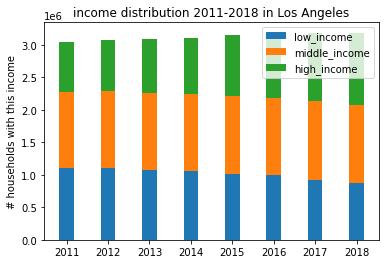

In [ ]:
labels = income["do_date"][8:16]
low_income = income["low_income"][8:16]
middle_income = income["middle_income"][8:16]
high_income = income["high_income"][8:16]
width = 0.35  
fig, ax = plt.subplots()
ax.bar(labels, low_income, width, label='low_income')
ax.bar(labels, middle_income, width, bottom=low_income,
       label='middle_income')
ax.bar(labels, high_income, width, bottom=low_income + middle_income,
       label='high_income')
ax.set_ylabel('# households with this income')
ax.set_title('income distribution 2011-2018 in Los Angeles')
ax.legend()

plt.show()

From the bar chart above, we can see that in the past 8 years, the proportion of high-income people in Los Angeles has been increasing year by year while the proportion of low-income people has shown a downward trend.

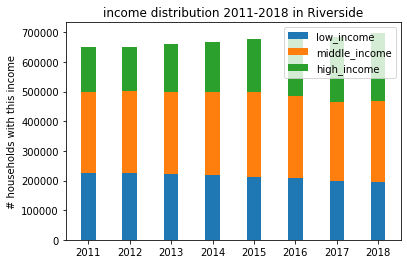

In [ ]:
labels = income["do_date"][24:32]
low_income = income["low_income"][24:32]
middle_income = income["middle_income"][24:32]
high_income = income["high_income"][24:32]
width = 0.35  
fig, ax = plt.subplots()
ax.bar(labels, low_income, width, label='low_income')
ax.bar(labels, middle_income, width, bottom=low_income,
       label='middle_income')
ax.bar(labels, high_income, width, bottom=low_income + middle_income,
       label='high_income')
ax.set_ylabel('# households with this income')
ax.set_title('income distribution 2011-2018 in Riverside')
ax.legend()

plt.show()

The proportion of people with different income levels in Riverside shares a similar trend with that in Los Angeles, which is manifested as a slight decrease in the number of low-income groups while the number of high-income groups has increased significantly.

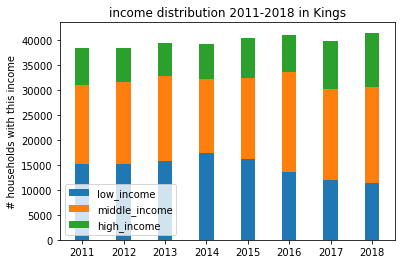

In [ ]:
labels = income["do_date"][0:8]
low_income = income["low_income"][0:8]
middle_income = income["middle_income"][0:8]
high_income = income["high_income"][0:8]
width = 0.35  
fig, ax = plt.subplots()
ax.bar(labels, low_income, width, label='low_income')
ax.bar(labels, middle_income, width, bottom=low_income,
       label='middle_income')
ax.bar(labels, high_income, width, bottom=low_income + middle_income,
       label='high_income')
ax.set_ylabel('# households with this income')
ax.set_title('income distribution 2011-2018 in Kings')
ax.legend()

plt.show()

For Kings, which has a negative population growth, the number of people with different income levels has fluctuated in the past 8 years, and there is no obvious growth or decline trend.

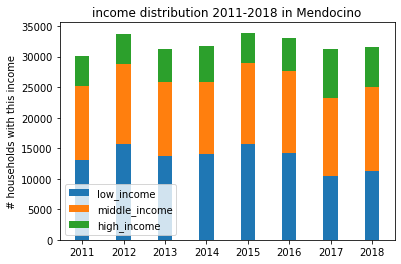

In [ ]:
labels = income["do_date"][16:24]
low_income = income["low_income"][16:24]
middle_income = income["middle_income"][16:24]
high_income = income["high_income"][16:24]
width = 0.35  
fig, ax = plt.subplots()
ax.bar(labels, low_income, width, label='low_income')
ax.bar(labels, middle_income, width, bottom=low_income,
       label='middle_income')
ax.bar(labels, high_income, width, bottom=low_income + middle_income,
       label='high_income')
ax.set_ylabel('# households with this income')
ax.set_title('income distribution 2011-2018 in Mendocino')
ax.legend()

plt.show()

For Mendocino, the city with the smallest population growth, the number of people with different income levels has also fluctuated in the past 8 years, with high values and low values alternately appearing, and there is no obvious trend of increase or decrease.

(2) demographic composition -- age analysis

We focus on the TOP5 counties with the most increase in population and the TOP5 counties with the least increase (or decrease) in population. 
To anaylze the age factor, We use the median age to observe the potential trend.

In [ ]:
%%bigquery --project $project_id factor_age

SELECT 
    do_date,counties.geo_id,median_age,counties.county_name
FROM (
    SELECT  
        do_date,median_age,geo_id
    FROM  `bigquery-public-data.census_bureau_acs.county_2011_1yr` Y2011
    union all
    SELECT 
        do_date,median_age,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2012_1yr` Y2012
    union all
    SELECT 
        do_date,median_age,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2013_1yr` Y2013
    union all
    SELECT 
        do_date,median_age,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2014_1yr` Y2014
    union all
    SELECT 
        do_date,median_age,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2015_1yr` Y2015
    union all
    SELECT 
        do_date,median_age,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2016_1yr` Y2016
    union all
    SELECT  
        do_date,median_age,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2017_1yr` Y2017
    union all
    SELECT 
        do_date,median_age,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2018_1yr` Y2018
    ) Y2011_2018,
    `bigquery-public-data.geo_us_boundaries.counties` counties
WHERE counties.geo_id = Y2011_2018.geo_id
AND counties.state_fips_code = "06"
ORDER BY geo_id, do_date

Then we save the above view as 'cs145-project3-331000.factor_analysis.median_age'

In [ ]:
%%bigquery --project $project_id median_age

SELECT *
FROM `cs145-project3-331000.factor_analysis.median_age`
WHERE county_name = "Napa"
OR county_name = "Nevada"
OR county_name = "Lake"
OR county_name = "Mendocino"
OR county_name = "Kings"
ORDER BY county_name,do_date

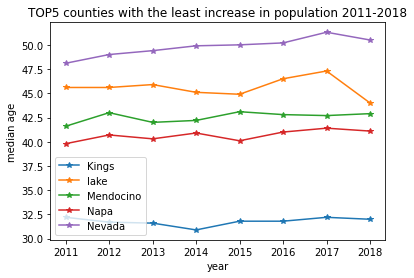

In [ ]:
x = median_age["do_date"][0:8]
y_kings = median_age["median_age"][0:8]
y_lake = median_age["median_age"][8:16]
y_mendocino = median_age["median_age"][16:24]
y_napa = median_age["median_age"][24:32]
y_nevada = median_age["median_age"][32:40]

plt.plot(x, y_kings, marker='*', label = "Kings")
plt.plot(x, y_lake, marker='*', label = "lake")
plt.plot(x, y_mendocino, marker='*', label = "Mendocino")
plt.plot(x, y_napa, marker='*', label = "Napa")
plt.plot(x, y_nevada, marker='*', label = "Nevada")
plt.legend()
plt.title("TOP5 counties with the least increase in population 2011-2018")
plt.xlabel("year")
plt.ylabel("median age")
plt.show()

For TOP 5 counties with the least population growth, in general, the median age of the population in all counties is relatively old (over 40 years old). In addition, except for the slight increase in the median age of the population of Nevada, the median age of the rest of the counties fluctuates slightly over past 8 years.

In [ ]:
%%bigquery --project $project_id median_age

SELECT *
FROM `cs145-project3-331000.factor_analysis.median_age`
WHERE county_name = "Riverside"
OR county_name = "Orange"
OR county_name = "Alameda"
OR county_name = "San Diego"
OR county_name = "Los Angeles"
ORDER BY county_name,do_date

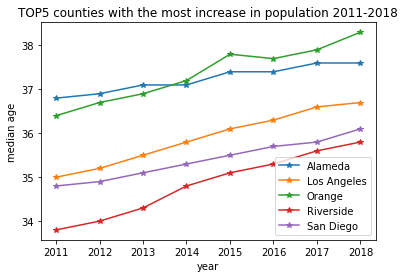

In [ ]:
x = median_age["do_date"][0:8]
y_Alameda = median_age["median_age"][0:8]
y_Los_Angeles = median_age["median_age"][8:16]
y_Orange = median_age["median_age"][16:24]
y_Riverside = median_age["median_age"][24:32]
y_San_Diego = median_age["median_age"][32:40]
plt.plot(x, y_Alameda, marker='*', label = "Alameda")
plt.plot(x, y_Los_Angeles, marker='*', label = "Los Angeles")
plt.plot(x, y_Orange, marker='*', label = "Orange")
plt.plot(x, y_Riverside, marker='*', label = "Riverside")
plt.plot(x, y_San_Diego, marker='*', label = "San Diego")
plt.legend()
plt.title("TOP5 counties with the most increase in population 2011-2018")
plt.xlabel("year")
plt.ylabel("median age")
plt.show()

When it comes to the TOP 5 counties with the most increase in population, the situation is totally diffrent. Compared to the TOP 5 counties with the least population growth, the median age of all these counties is relatively young and has an obvious trend of increasing year by year.

(3) demographic composition -- Educational Attainment

First of all, we observed and compared the overall distribution of the proportion of people with high education attainment in the first and last year of the study period.

In [ ]:
%%bigquery --project $project_id educational_attainment

SELECT 
    do_date,counties.geo_id,counties.county_name,bachelors_degree_or_higher_25_64, pop_25_64,
    ROUND((bachelors_degree_or_higher_25_64/pop_25_64),2) AS percent_high_educational_attainment
FROM (
    SELECT  
        do_date,geo_id,bachelors_degree_or_higher_25_64, pop_25_64
    FROM  `bigquery-public-data.census_bureau_acs.county_2011_1yr` Y2011
    union all
    SELECT 
        do_date,geo_id,bachelors_degree_or_higher_25_64, pop_25_64
    from  `bigquery-public-data.census_bureau_acs.county_2012_1yr` Y2012
    union all
    SELECT 
        do_date,geo_id,bachelors_degree_or_higher_25_64, pop_25_64
    from  `bigquery-public-data.census_bureau_acs.county_2013_1yr` Y2013
    union all
    SELECT 
        do_date,geo_id,bachelors_degree_or_higher_25_64, pop_25_64
    from  `bigquery-public-data.census_bureau_acs.county_2014_1yr` Y2014
    union all
    SELECT 
        do_date,geo_id,bachelors_degree_or_higher_25_64, pop_25_64
    from  `bigquery-public-data.census_bureau_acs.county_2015_1yr` Y2015
    union all
    SELECT 
        do_date,geo_id,bachelors_degree_or_higher_25_64, pop_25_64
    from  `bigquery-public-data.census_bureau_acs.county_2016_1yr` Y2016
    union all
    SELECT  
        do_date,geo_id,bachelors_degree_or_higher_25_64, pop_25_64
    from  `bigquery-public-data.census_bureau_acs.county_2017_1yr` Y2017
    union all
    SELECT 
        do_date,geo_id,bachelors_degree_or_higher_25_64, pop_25_64
    from  `bigquery-public-data.census_bureau_acs.county_2018_1yr` Y2018
    ) Y2011_2018,
    `bigquery-public-data.geo_us_boundaries.counties` counties
WHERE counties.geo_id = Y2011_2018.geo_id
AND counties.state_fips_code = "06"
ORDER BY geo_id, do_date

(0.1, 0.7)

<Figure size 432x288 with 0 Axes>

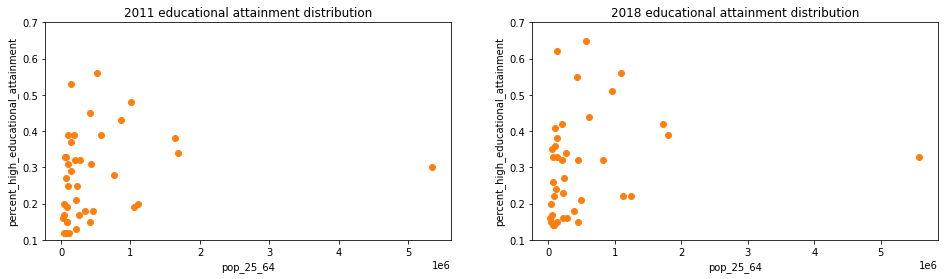

In [ ]:
plt.figure()
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
for i in range(0, 321, 8):
  x = educational_attainment["pop_25_64"][i:i+1]
  y = educational_attainment["percent_high_educational_attainment"][i:i+1]
  plt.scatter(x, y, c='#ff7f0e')

plt.title("2011 educational attainment distribution")
plt.xlabel("pop_25_64")
plt.ylabel("percent_high_educational_attainment")
plt.ylim(0.1, 0.7)

plt.subplot(1, 2, 2)
for i in range(7, 328, 8):
  x = educational_attainment["pop_25_64"][i:i+1]
  y = educational_attainment["percent_high_educational_attainment"][i:i+1]
  plt.scatter(x, y, c='#ff7f0e')

plt.title("2018 educational attainment distribution")
plt.xlabel("pop_25_64")
plt.ylabel("percent_high_educational_attainment")
plt.ylim(0.1, 0.7)

From the above scatter charts, we can clearly see that compared with 2011, California's overall propotion of peope with high educational attainment has slightly increased in 2018.

Next, we observed and compared the trend of the propotion change of population with high educational attainment in TOP 5 regions with high population inflow with that of TOP 5 regions with low population inflow.

In [ ]:
%%bigquery --project $project_id educational_most_increasePop

SELECT percent_high_educational_attainment, do_date, county_name
FROM `cs145-project3-331000.factor_analysis.education`
WHERE county_name = "Riverside"
OR county_name = "Orange"
OR county_name = "Alameda"
OR county_name = "San Diego"
OR county_name = "Los Angeles"
ORDER BY county_name,do_date

In [ ]:
%%bigquery --project $project_id educational_least_increasePop
SELECT percent_high_educational_attainment, do_date, county_name
FROM `cs145-project3-331000.factor_analysis.education`
WHERE county_name = "Napa"
OR county_name = "Nevada"
OR county_name = "Lake"
OR county_name = "Mendocino"
OR county_name = "Kings"
ORDER BY county_name,do_date

(0.1, 0.6)

<Figure size 432x288 with 0 Axes>

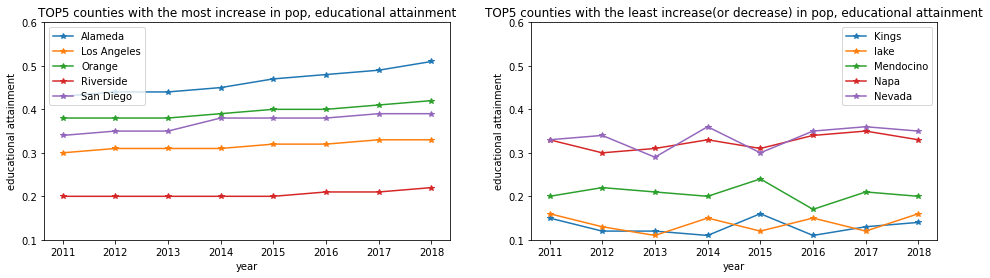

In [ ]:
plt.figure()
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)

x = educational_most_increasePop["do_date"][0:8]
y_Alameda = educational_most_increasePop["percent_high_educational_attainment"][0:8]
y_Los_Angeles = educational_most_increasePop["percent_high_educational_attainment"][8:16]
y_Orange = educational_most_increasePop["percent_high_educational_attainment"][16:24]
y_Riverside = educational_most_increasePop["percent_high_educational_attainment"][24:32]
y_San_Diego = educational_most_increasePop["percent_high_educational_attainment"][32:40]
plt.plot(x, y_Alameda, marker='*', label = "Alameda")
plt.plot(x, y_Los_Angeles, marker='*', label = "Los Angeles")
plt.plot(x, y_Orange, marker='*', label = "Orange")
plt.plot(x, y_Riverside, marker='*', label = "Riverside")
plt.plot(x, y_San_Diego, marker='*', label = "San Diego")
plt.legend()
plt.title("TOP5 counties with the most increase in pop, educational attainment")
plt.xlabel("year")
plt.ylabel("educational attainment")
plt.ylim(0.1, 0.6)

plt.subplot(1, 2, 2)
x = educational_least_increasePop["do_date"][0:8]
y_kings = educational_least_increasePop["percent_high_educational_attainment"][0:8]
y_lake = educational_least_increasePop["percent_high_educational_attainment"][8:16]
y_mendocino = educational_least_increasePop["percent_high_educational_attainment"][16:24]
y_napa = educational_least_increasePop["percent_high_educational_attainment"][24:32]
y_nevada = educational_least_increasePop["percent_high_educational_attainment"][32:40]

plt.plot(x, y_kings, marker='*', label = "Kings")
plt.plot(x, y_lake, marker='*', label = "lake")
plt.plot(x, y_mendocino, marker='*', label = "Mendocino")
plt.plot(x, y_napa, marker='*', label = "Napa")
plt.plot(x, y_nevada, marker='*', label = "Nevada")
plt.legend()
plt.title("TOP5 counties with the least increase(or decrease) in pop, educational attainment")
plt.xlabel("year")
plt.ylabel("educational attainment")
plt.ylim(0.1, 0.6)

In general, the trends of the proportion change of population with high educational attainment in TOP 5 regions with high population and TOP 5 regions with low population inflow are quite different. The proportion of people with high educational attainment in the TOP 5 regions with the most increse in population is relatively high, and has remained constant or slightly increased during the study period, while the proportion in the TOP 5 counties with the least increse in population is relatively low and fluctuated greatly in the past 8 years.

(3) demographic composition -- House rent

we choose percent_income_spent_on_rent to conduct our analysis to discuss the relationship between house rent and population growth in selected representative counties in California.

In [10]:
%%bigquery --project $project_id factor_rent

SELECT 
    do_date,counties.geo_id,counties.county_name,percent_income_spent_on_rent
FROM (
    SELECT  
        do_date,percent_income_spent_on_rent,geo_id
    FROM  `bigquery-public-data.census_bureau_acs.county_2011_1yr` Y2011
    union all
    SELECT 
        do_date,percent_income_spent_on_rent,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2012_1yr` Y2012
    union all
    SELECT 
        do_date,percent_income_spent_on_rent,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2013_1yr` Y2013
    union all
    SELECT 
        do_date,percent_income_spent_on_rent,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2014_1yr` Y2014
    union all
    SELECT 
        do_date,percent_income_spent_on_rent,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2015_1yr` Y2015
    union all
    SELECT 
        do_date,percent_income_spent_on_rent,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2016_1yr` Y2016
    union all
    SELECT  
        do_date,percent_income_spent_on_rent,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2017_1yr` Y2017
    union all
    SELECT 
        do_date,percent_income_spent_on_rent,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2018_1yr` Y2018
    ) Y2011_2018,
    `bigquery-public-data.geo_us_boundaries.counties` counties
WHERE counties.geo_id = Y2011_2018.geo_id
AND counties.state_fips_code = "06"
ORDER BY do_date

Then we save the above view as 'cs145-project3-331000.factor_analysis.rent'

In [11]:
%%bigquery --project $project_id rent_most_increasePop
SELECT percent_income_spent_on_rent, do_date, county_name
FROM `cs145-project3-331000.factor_analysis.rent`
WHERE county_name = "Riverside"
OR county_name = "Orange"
OR county_name = "Alameda"
OR county_name = "San Diego"
OR county_name = "Los Angeles"
ORDER BY county_name,do_date

In [12]:
%%bigquery --project $project_id rent_least_increasePop
SELECT percent_income_spent_on_rent, do_date, county_name
FROM `cs145-project3-331000.factor_analysis.rent`
WHERE county_name = "Napa"
OR county_name = "Nevada"
OR county_name = "Lake"
OR county_name = "Mendocino"
OR county_name = "Kings"
ORDER BY county_name,do_date

(20.0, 50.0)

<Figure size 432x288 with 0 Axes>

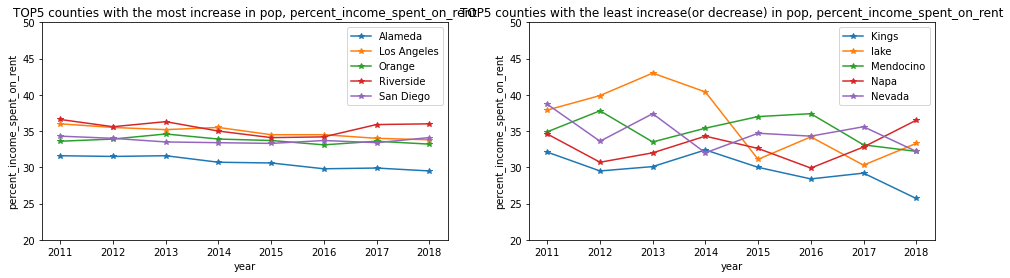

In [15]:
plt.figure()
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)

x = rent_most_increasePop["do_date"][0:8]
y_Alameda = rent_most_increasePop["percent_income_spent_on_rent"][0:8]
y_Los_Angeles = rent_most_increasePop["percent_income_spent_on_rent"][8:16]
y_Orange = rent_most_increasePop["percent_income_spent_on_rent"][16:24]
y_Riverside = rent_most_increasePop["percent_income_spent_on_rent"][24:32]
y_San_Diego = rent_most_increasePop["percent_income_spent_on_rent"][32:40]
plt.plot(x, y_Alameda, marker='*', label = "Alameda")
plt.plot(x, y_Los_Angeles, marker='*', label = "Los Angeles")
plt.plot(x, y_Orange, marker='*', label = "Orange")
plt.plot(x, y_Riverside, marker='*', label = "Riverside")
plt.plot(x, y_San_Diego, marker='*', label = "San Diego")
plt.legend()
plt.title("TOP5 counties with the most increase in pop, percent_income_spent_on_rent")
plt.xlabel("year")
plt.ylabel("percent_income_spent_on_rent")
plt.ylim(20, 50)

plt.subplot(1, 2, 2)
x = rent_least_increasePop["do_date"][0:8]
y_kings = rent_least_increasePop["percent_income_spent_on_rent"][0:8]
y_lake = rent_least_increasePop["percent_income_spent_on_rent"][8:16]
y_mendocino = rent_least_increasePop["percent_income_spent_on_rent"][16:24]
y_napa = rent_least_increasePop["percent_income_spent_on_rent"][24:32]
y_nevada = rent_least_increasePop["percent_income_spent_on_rent"][32:40]

plt.plot(x, y_kings, marker='*', label = "Kings")
plt.plot(x, y_lake, marker='*', label = "lake")
plt.plot(x, y_mendocino, marker='*', label = "Mendocino")
plt.plot(x, y_napa, marker='*', label = "Napa")
plt.plot(x, y_nevada, marker='*', label = "Nevada")
plt.legend()
plt.title("TOP5 counties with the least increase(or decrease) in pop, percent_income_spent_on_rent")
plt.xlabel("year")
plt.ylabel("percent_income_spent_on_rent")
plt.ylim(20, 50)

From the above line charts, we can find out that the trends of the percent of income spent on house rent in the TOP 5 counties with the most increase in population remains almost constant or slightly decreased during the study period while those in the TOP 5 counties with the least population growth fluctuated violently.

(4) demographic composition -- Employment

In this part, we will calculate the employment rate to analyze the relationship between the employment rate and population growth in California.


In [16]:
%%bigquery --project $project_id factor_employment

SELECT 
    do_date,counties.geo_id,counties.county_name, employment_rate
FROM (
    SELECT  
        do_date,employed_pop/total_pop AS employment_rate,geo_id
    FROM  `bigquery-public-data.census_bureau_acs.county_2011_1yr` Y2011
    union all
    SELECT 
        do_date,employed_pop/total_pop AS employment_rate,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2012_1yr` Y2012
    union all
    SELECT 
        do_date,employed_pop/total_pop AS employment_rate,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2013_1yr` Y2013
    union all
    SELECT 
        do_date,employed_pop/total_pop AS employment_rate,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2014_1yr` Y2014
    union all
    SELECT 
        do_date,employed_pop/total_pop AS employment_rate,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2015_1yr` Y2015
    union all
    SELECT 
        do_date,employed_pop/total_pop AS employment_rate,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2016_1yr` Y2016
    union all
    SELECT  
        do_date,employed_pop/total_pop AS employment_rate,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2017_1yr` Y2017
    union all
    SELECT 
        do_date,employed_pop/total_pop AS employment_rate,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2018_1yr` Y2018
    ) Y2011_2018,
    `bigquery-public-data.geo_us_boundaries.counties` counties
WHERE counties.geo_id = Y2011_2018.geo_id
AND counties.state_fips_code = "06"
ORDER BY do_date

Then we save the above view as 'cs145-project3-331000.factor_analysis.employment'

Firstly, we analyzed the overall change of the average employment rate in California in the past 8 years.

In [18]:
%%bigquery --project $project_id overall_employment_rate

SELECT do_date,avg(employment_rate) AS avg_employment_rate
FROM `cs145-project3-331000.factor_analysis.employment`
WHERE employment_rate IS NOT NULL
GROUP BY do_date
ORDER BY do_date

Text(0, 0.5, 'avg_employment_rate')

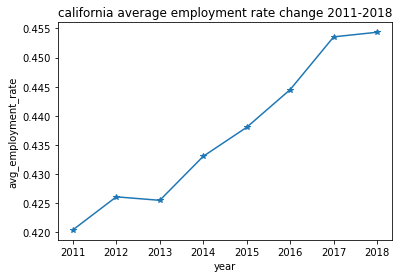

In [19]:
x = overall_employment_rate["do_date"]
y = overall_employment_rate["avg_employment_rate"]
plt.plot(x, y, marker='*',label = "california avg_employment_rate")
plt.title("california average employment rate change 2011-2018")
plt.xlabel("year")
plt.ylabel("avg_employment_rate")

It is shown in the line chart above that the average employment rate in California has continuously increased year by year.

Then, we analyzed the employment rates in the TOP5 counties with the most increase in population and the TOP5 counties with the least increase (or decrease) in population and compare their trends in the past 8 years.

In [20]:
%%bigquery --project $project_id employment_most_increasePop
SELECT employment_rate, do_date, county_name
FROM `cs145-project3-331000.factor_analysis.employment`
WHERE county_name = "Riverside"
OR county_name = "Orange"
OR county_name = "Alameda"
OR county_name = "San Diego"
OR county_name = "Los Angeles"
ORDER BY county_name,do_date

In [21]:
%%bigquery --project $project_id employment_least_increasePop
SELECT employment_rate, do_date, county_name
FROM `cs145-project3-331000.factor_analysis.employment`
WHERE county_name = "Napa"
OR county_name = "Nevada"
OR county_name = "Lake"
OR county_name = "Mendocino"
OR county_name = "Kings"
ORDER BY county_name,do_date

(0.2, 0.6)

<Figure size 432x288 with 0 Axes>

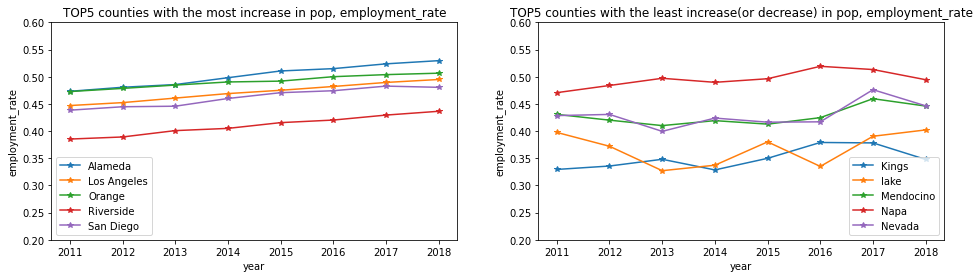

In [22]:
plt.figure()
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)

x = employment_most_increasePop["do_date"][0:8]
y_Alameda = employment_most_increasePop["employment_rate"][0:8]
y_Los_Angeles = employment_most_increasePop["employment_rate"][8:16]
y_Orange = employment_most_increasePop["employment_rate"][16:24]
y_Riverside = employment_most_increasePop["employment_rate"][24:32]
y_San_Diego = employment_most_increasePop["employment_rate"][32:40]
plt.plot(x, y_Alameda, marker='*', label = "Alameda")
plt.plot(x, y_Los_Angeles, marker='*', label = "Los Angeles")
plt.plot(x, y_Orange, marker='*', label = "Orange")
plt.plot(x, y_Riverside, marker='*', label = "Riverside")
plt.plot(x, y_San_Diego, marker='*', label = "San Diego")
plt.legend()
plt.title("TOP5 counties with the most increase in pop, employment_rate")
plt.xlabel("year")
plt.ylabel("employment_rate")
plt.ylim(0.2, 0.6)

plt.subplot(1, 2, 2)
x = employment_least_increasePop["do_date"][0:8]
y_kings = employment_least_increasePop["employment_rate"][0:8]
y_lake = employment_least_increasePop["employment_rate"][8:16]
y_mendocino = employment_least_increasePop["employment_rate"][16:24]
y_napa = employment_least_increasePop["employment_rate"][24:32]
y_nevada = employment_least_increasePop["employment_rate"][32:40]

plt.plot(x, y_kings, marker='*', label = "Kings")
plt.plot(x, y_lake, marker='*', label = "lake")
plt.plot(x, y_mendocino, marker='*', label = "Mendocino")
plt.plot(x, y_napa, marker='*', label = "Napa")
plt.plot(x, y_nevada, marker='*', label = "Nevada")
plt.legend()
plt.title("TOP5 counties with the least increase(or decrease) in pop, employment_rate")
plt.xlabel("year")
plt.ylabel("employment_rate")
plt.ylim(0.2, 0.6)

The line charts above illustrate that for all TOP 5 counties with the most increase in population, employment rates have been growing slowly but steadily. On the contrary, the employment rates in the TOP 5 counties with the least population growth have been fluctuating and very unstable.

(5) demographic composition -- Race

We choose asian, black, white, amerindian, other race to conduct our analysis.

In [ ]:
%%bigquery --project $project_id race_raw

SELECT 
    do_date,counties.geo_id,counties.county_name,asian_pop, 
    black_pop, white_pop, amerindian_pop, other_race_pop
FROM (
    SELECT  
        do_date,geo_id,asian_pop, black_pop, white_pop, amerindian_pop, other_race_pop
    FROM  `bigquery-public-data.census_bureau_acs.county_2011_1yr` Y2011
    union all
    SELECT 
        do_date,geo_id,asian_pop, black_pop, white_pop, amerindian_pop, other_race_pop
    from  `bigquery-public-data.census_bureau_acs.county_2012_1yr` Y2012
    union all
    SELECT 
        do_date,geo_id,asian_pop, black_pop, white_pop, amerindian_pop, other_race_pop
    from  `bigquery-public-data.census_bureau_acs.county_2013_1yr` Y2013
    union all
    SELECT 
        do_date,geo_id,asian_pop, black_pop, white_pop, amerindian_pop, other_race_pop
    from  `bigquery-public-data.census_bureau_acs.county_2014_1yr` Y2014
    union all
    SELECT 
        do_date,geo_id,asian_pop, black_pop, white_pop, amerindian_pop, other_race_pop
    from  `bigquery-public-data.census_bureau_acs.county_2015_1yr` Y2015
    union all
    SELECT 
        do_date,geo_id,asian_pop, black_pop, white_pop, amerindian_pop, other_race_pop
    from  `bigquery-public-data.census_bureau_acs.county_2016_1yr` Y2016
    union all
    SELECT  
        do_date,geo_id,asian_pop, black_pop, white_pop, amerindian_pop, other_race_pop
    from  `bigquery-public-data.census_bureau_acs.county_2017_1yr` Y2017
    union all
    SELECT 
        do_date,geo_id,asian_pop, black_pop, white_pop, amerindian_pop, other_race_pop
    from  `bigquery-public-data.census_bureau_acs.county_2018_1yr` Y2018
    ) Y2011_2018,
    `bigquery-public-data.geo_us_boundaries.counties` counties
WHERE counties.geo_id = Y2011_2018.geo_id
AND counties.state_fips_code = "06"
ORDER BY geo_id, do_date

We save the above view as `cs145-project3-331000.factor_analysis.race`

In [ ]:
%%bigquery --project $project_id race_pop_growth_rate

SELECT t1.do_date, t1.geo_id,t1.county_name,
    if(t2.total_black_pop = 0, 0, ROUND(t1.total_black_pop/t2.total_black_pop-1, 3)) AS black_pop_growth_rate,
    if(t2.total_white_pop = 0, 0, ROUND(t1.total_white_pop/t2.total_white_pop-1, 3)) AS white_pop_growth_rate,
    if(t2.total_asian_pop = 0, 0, ROUND(t1.total_asian_pop/t2.total_asian_pop-1, 3)) AS asian_pop_growth_rate,
    if(t2.total_amerindian_pop = 0, 0, ROUND(t1.total_amerindian_pop/t2.total_amerindian_pop-1, 3)) AS amerindian_pop_growth_rate,
    if(t2.total_other_race_pop = 0, 0, ROUND(t1.total_other_race_pop/t2.total_other_race_pop-1, 3)) AS other_race_pop_growth_rate,
FROM 
     (SELECT 
      geo_id,
      county_name,
      do_date,
      sum(asian_pop) as total_asian_pop,
      sum(white_pop) as total_white_pop,
      sum(amerindian_pop) as total_amerindian_pop,
      sum(black_pop) as total_black_pop,
      sum(other_race_pop) as total_other_race_pop
  FROM `cs145-project3-331000.factor_analysis.race`
  WHERE 
      asian_pop IS NOT NULL
      AND white_pop IS NOT NULL
      AND amerindian_pop IS NOT NULL
      AND black_pop IS NOT NULL
      AND other_race_pop IS NOT NULL
  GROUP BY geo_id, county_name, do_date
  ORDER BY county_name, do_date) t1, 
     (SELECT 
      geo_id,
      county_name,
      do_date,
      sum(asian_pop) as total_asian_pop,
      sum(white_pop) as total_white_pop,
      sum(amerindian_pop) as total_amerindian_pop,
      sum(black_pop) as total_black_pop,
      sum(other_race_pop) as total_other_race_pop
  FROM `cs145-project3-331000.factor_analysis.race`
  WHERE 
      asian_pop IS NOT NULL
      AND white_pop IS NOT NULL
      AND amerindian_pop IS NOT NULL
      AND black_pop IS NOT NULL
      AND other_race_pop IS NOT NULL
  GROUP BY geo_id, county_name, do_date
  ORDER BY county_name, do_date) t2 
WHERE CAST(t1.do_date AS INT) = CAST(t2.do_date AS INT) + 1
    AND t1.geo_id = t2.geo_id
ORDER BY t1.county_name, t1.do_date

Text(0.5, 0, 'year')

<Figure size 432x288 with 0 Axes>

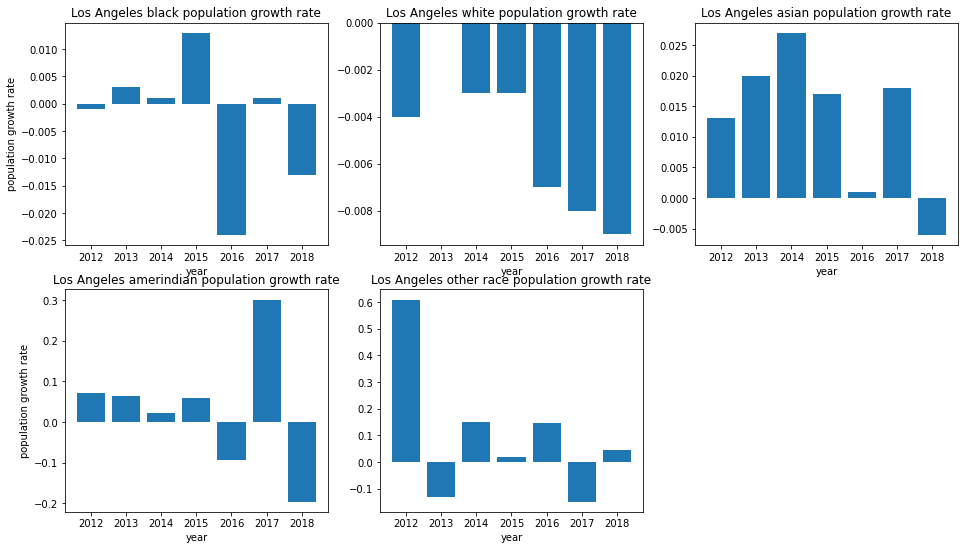

In [ ]:
plt.figure()
plt.figure(figsize=(16, 9))

labels = race_pop_growth_rate["do_date"][62:69]
black_pop_growth_rate = race_pop_growth_rate["black_pop_growth_rate"][62:69]
white_pop_growth_rate = race_pop_growth_rate["white_pop_growth_rate"][62:69]
asian_pop_growth_rate = race_pop_growth_rate["asian_pop_growth_rate"][62:69]
amerindian_pop_growth_rate = race_pop_growth_rate["amerindian_pop_growth_rate"][62:69]
other_race_pop_growth_rate = race_pop_growth_rate["other_race_pop_growth_rate"][62:69]

plt.subplot(2, 3, 1)
plt.bar(labels, black_pop_growth_rate)
plt.title("Los Angeles black population growth rate")
plt.xlabel("year")
plt.ylabel("population growth rate")

plt.subplot(2, 3, 2)
plt.bar(labels, white_pop_growth_rate)
plt.title("Los Angeles white population growth rate")
plt.xlabel("year")

plt.subplot(2, 3, 3)
plt.bar(labels, asian_pop_growth_rate)
plt.title("Los Angeles asian population growth rate")
plt.xlabel("year")

plt.subplot(2, 3, 4)
plt.bar(labels, amerindian_pop_growth_rate)
plt.title("Los Angeles amerindian population growth rate")
plt.xlabel("year")
plt.ylabel("population growth rate")

plt.subplot(2, 3, 5)
plt.bar(labels, other_race_pop_growth_rate)
plt.title("Los Angeles other race population growth rate")
plt.xlabel("year")

In this part, we found that population growth rates of different races in different counties have been fluctuating in the past 8 years, so we did not find any typical change characteristics.

(6) demographic composition -- Family_households rate

In this part, we are going to analyze the relationship between the family_households rate(family_households/households) and population growth in selected representative counties in California.

In [24]:
%%bigquery --project $project_id factor_family_households
SELECT 
    do_date,counties.geo_id,counties.county_name,family_households_rate 
FROM (
    SELECT  
        do_date,family_households/households AS family_households_rate, geo_id
    FROM  `bigquery-public-data.census_bureau_acs.county_2011_1yr` Y2011
    union all
    SELECT 
        do_date,family_households/households AS family_households_rate,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2012_1yr` Y2012
    union all
    SELECT 
        do_date,family_households/households AS family_households_rate,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2013_1yr` Y2013
    union all
    SELECT 
        do_date,family_households/households AS family_households_rate,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2014_1yr` Y2014
    union all
    SELECT 
        do_date,family_households/households AS family_households_rate,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2015_1yr` Y2015
    union all
    SELECT 
        do_date,family_households/households AS family_households_rate,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2016_1yr` Y2016
    union all
    SELECT  
        do_date,family_households/households AS family_households_rate,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2017_1yr` Y2017
    union all
    SELECT 
        do_date,family_households/households AS family_households_rate,geo_id
    from  `bigquery-public-data.census_bureau_acs.county_2018_1yr` Y2018
    ) Y2011_2018,
    `bigquery-public-data.geo_us_boundaries.counties` counties
WHERE counties.geo_id = Y2011_2018.geo_id
AND counties.state_fips_code = "06"
ORDER BY do_date

We save the above view as `cs145-project3-331000.factor_analysis.family_households`

In [25]:
%%bigquery --project $project_id family_households_most_increasePop
SELECT family_households_rate, do_date, county_name
FROM `cs145-project3-331000.factor_analysis.family_households`
WHERE county_name = "Riverside"
OR county_name = "Orange"
OR county_name = "Alameda"
OR county_name = "San Diego"
OR county_name = "Los Angeles"
ORDER BY county_name,do_date

In [26]:
%%bigquery --project $project_id family_households_least_increasePop
SELECT family_households_rate, do_date, county_name
FROM `cs145-project3-331000.factor_analysis.family_households`
WHERE county_name = "Napa"
OR county_name = "Nevada"
OR county_name = "Lake"
OR county_name = "Mendocino"
OR county_name = "Kings"
ORDER BY county_name,do_date

(0.5, 0.85)

<Figure size 432x288 with 0 Axes>

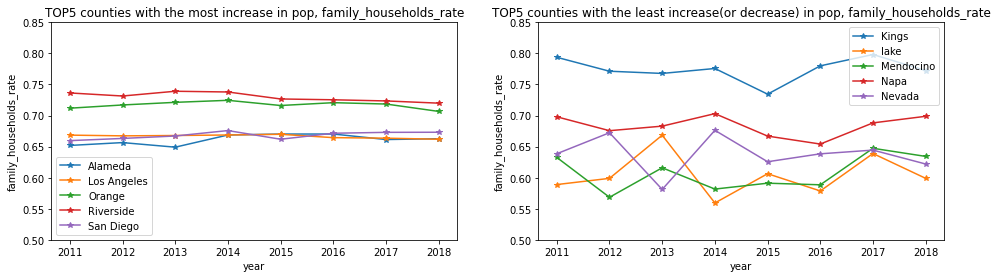

In [29]:
plt.figure()
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)

x = family_households_most_increasePop["do_date"][0:8]
y_Alameda = family_households_most_increasePop["family_households_rate"][0:8]
y_Los_Angeles = family_households_most_increasePop["family_households_rate"][8:16]
y_Orange = family_households_most_increasePop["family_households_rate"][16:24]
y_Riverside = family_households_most_increasePop["family_households_rate"][24:32]
y_San_Diego = family_households_most_increasePop["family_households_rate"][32:40]
plt.plot(x, y_Alameda, marker='*', label = "Alameda")
plt.plot(x, y_Los_Angeles, marker='*', label = "Los Angeles")
plt.plot(x, y_Orange, marker='*', label = "Orange")
plt.plot(x, y_Riverside, marker='*', label = "Riverside")
plt.plot(x, y_San_Diego, marker='*', label = "San Diego")
plt.legend()
plt.title("TOP5 counties with the most increase in pop, family_households_rate")
plt.xlabel("year")
plt.ylabel("family_households_rate")
plt.ylim(0.5, 0.85)

plt.subplot(1, 2, 2)
x = family_households_least_increasePop["do_date"][0:8]
y_kings = family_households_least_increasePop["family_households_rate"][0:8]
y_lake = family_households_least_increasePop["family_households_rate"][8:16]
y_mendocino = family_households_least_increasePop["family_households_rate"][16:24]
y_napa = family_households_least_increasePop["family_households_rate"][24:32]
y_nevada = family_households_least_increasePop["family_households_rate"][32:40]

plt.plot(x, y_kings, marker='*', label = "Kings")
plt.plot(x, y_lake, marker='*', label = "lake")
plt.plot(x, y_mendocino, marker='*', label = "Mendocino")
plt.plot(x, y_napa, marker='*', label = "Napa")
plt.plot(x, y_nevada, marker='*', label = "Nevada")
plt.legend()
plt.title("TOP5 counties with the least increase(or decrease) in pop, family_households_rate")
plt.xlabel("year")
plt.ylabel("family_households_rate")
plt.ylim(0.5, 0.85)

As is shown in the above charts, the family_households rates in the TOP 5 counties with the most population growth remain stable whereas those in the TOP 5 counties with the least population growth fluctuated greatly during the study period. 

## Data Prediction

In [33]:
%%bigquery --project $project_id cal_all

SELECT zip_code, county, city, do_date, geo_id, total_pop, income_less_10000, income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,
        income_30000_34999,income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
        income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more, median_age, bachelors_degree_or_higher_25_64, pop_25_64,
        percent_income_spent_on_rent, family_households, households, employed_pop
FROM (
    SELECT  
        do_date, geo_id, total_pop, income_less_10000, income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,
        income_30000_34999,income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
        income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more, median_age, bachelors_degree_or_higher_25_64, pop_25_64,
        percent_income_spent_on_rent, family_households, households, employed_pop
    FROM  `bigquery-public-data.census_bureau_acs.zip_codes_2011_5yr` Y2011
    union all
    SELECT 
        do_date, geo_id, total_pop, income_less_10000, income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,
        income_30000_34999,income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
        income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more, median_age, bachelors_degree_or_higher_25_64, pop_25_64,
        percent_income_spent_on_rent, family_households, households, employed_pop
    from  `bigquery-public-data.census_bureau_acs.zip_codes_2012_5yr` Y2012
    union all
    SELECT 
        do_date, geo_id, total_pop, income_less_10000, income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,
    income_30000_34999,income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
    income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more, median_age, bachelors_degree_or_higher_25_64, pop_25_64,
    percent_income_spent_on_rent, family_households, households, employed_pop
    from  `bigquery-public-data.census_bureau_acs.zip_codes_2013_5yr` Y2013
    union all
    SELECT 
        do_date, geo_id, total_pop, income_less_10000, income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,
    income_30000_34999,income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
    income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more, median_age, bachelors_degree_or_higher_25_64, pop_25_64,
    percent_income_spent_on_rent, family_households, households, employed_pop
    from  `bigquery-public-data.census_bureau_acs.zip_codes_2014_5yr` Y2014
    union all
    SELECT 
        do_date, geo_id, total_pop, income_less_10000, income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,
    income_30000_34999,income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
    income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more, median_age, bachelors_degree_or_higher_25_64, pop_25_64,
    percent_income_spent_on_rent, family_households, households, employed_pop
    from  `bigquery-public-data.census_bureau_acs.zip_codes_2015_5yr` Y2015
    union all
    SELECT 
        do_date, geo_id, total_pop, income_less_10000, income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,
    income_30000_34999,income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
    income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more, median_age, bachelors_degree_or_higher_25_64, pop_25_64,
    percent_income_spent_on_rent, family_households, households, employed_pop
    from  `bigquery-public-data.census_bureau_acs.zip_codes_2016_5yr` Y2016
    union all
    SELECT  
        do_date, geo_id, total_pop, income_less_10000, income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,
    income_30000_34999,income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
    income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more, median_age, bachelors_degree_or_higher_25_64, pop_25_64,
    percent_income_spent_on_rent, family_households, households, employed_pop
    from  `bigquery-public-data.census_bureau_acs.zip_codes_2017_5yr` Y2017
    union all
    SELECT 
        CAST(do_date AS string), geo_id, total_pop, income_less_10000, income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,
    income_30000_34999,income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,
    income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more, median_age, bachelors_degree_or_higher_25_64, pop_25_64,
    percent_income_spent_on_rent, family_households, households, employed_pop
    from  `bigquery-public-data.census_bureau_acs.zip_codes_2018_5yr` Y2018
    ) Y2011_2018,
    `bigquery-public-data.geo_us_boundaries.zip_codes` zip_codes
WHERE zip_codes.zip_code = Y2011_2018.geo_id
AND zip_codes.state_fips_code = "06"
ORDER BY do_date

we saved the above view as cs145-project3-331000.factor_analysis.zipcode_allFactors

In [34]:
%%bigquery --project $project_id all_urban_zipcode

SELECT 
  distinct(urban_area_code), all_area.zip_code, lsad_name
FROM 
  `bigquery-public-data.geo_us_boundaries.urban_areas` area,
  `cs145-project3-331000.factor_analysis.zipcode_all_factors` all_area,
  `bigquery-public-data.geo_us_boundaries.zip_codes` zipcodes
WHERE 
  ST_CONTAINS(area.urban_area_geom, zipcodes.internal_point_geom)
  AND zipcodes.zip_code = all_area.zip_code
ORDER BY zip_code, urban_area_code

we save the above view as `cs145-project3-331000.factor_analysis.urban_zip`

The above table includes all zipcodes in the urban area. When we are building a model, if a zipcode belongs to an urban area, it is 1; otherwise, it is 0.

**Extract training data:**

In [58]:
%%bigquery --project $project_id factors

SELECT 
    zip_code,
    year + 4 AS do_year,
    age_growth_rate AS F_medianAge_growth,
    (CASE WHEN population.pop_growth_rate < 0 THEN 1
    WHEN population.pop_growth_rate BETWEEN 0 AND 0.1 THEN 2
    WHEN population.pop_growth_rate > 0.1 THEN 3
    END) AS label,
    ROUND((income_less_10000 + income_10000_14999 + income_15000_19999 + income_20000_24999 + income_30000_34999 +
    income_35000_39999) / (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more),3) AS F_low_high_income_ratio,
    ROUND((bachelors_degree_or_higher_25_64 / pop_25_64),3) AS F_advanced_education_rate,
    ROUND((family_households / households),3) AS F_family_households_rate,
    percent_income_spent_on_rent AS F_house_rent,
    ROUND((employed_pop / total_pop),3) AS F_employment_rate,
    IF(zip_code IN 
    (SELECT zip_code FROM `cs145-project3-331000.factor_analysis.urban_zip`), 1, 0) AS F_urban
FROM 
    `cs145-project3-331000.factor_analysis.zipcode_allFactors` all_factor,
    (   SELECT t1.year, t1.geo_id,
            if(t2.total_pop = 0, 1, ROUND(t1.total_pop/t2.total_pop-1, 3)) AS pop_growth_rate,
            ROUND(t1.median_age/t2.median_age-1, 3) AS age_growth_rate,
        FROM  
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t1, 
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t2 
        WHERE CAST(t1.year AS INT) = CAST(t2.year AS INT) + 1
            AND t1.geo_id = t2.geo_id) population
WHERE pop_25_64 <> 0 
    AND (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more) <> 0
    AND population.geo_id = all_factor.geo_id
    AND CAST(population.year AS STRING) like CAST(substr(CAST(do_date AS string), 1, 4) AS STRING)
ORDER BY label, zip_code, do_date, pop_growth_rate
LIMIT 10

In [59]:
factors

,zip_code,do_year,F_medianAge_growth,label,F_low_high_income_ratio,F_advanced_education_rate,F_family_households_rate,F_house_rent,F_employment_rate,F_urban
0,90001,2016,-0.004,1,6.589,0.045,0.837,42.0,0.390,1
1,90003,2017,-0.011,1,6.854,0.055,0.807,48.8,0.380,1
2,90004,2016,0.017,1,2.061,0.344,0.597,34.1,0.527,1
3,90004,2017,0.008,1,1.758,0.344,0.585,33.8,0.546,1
4,90005,2016,0.009,1,6.757,0.292,0.527,37.6,0.530,1
5,90005,2017,-0.006,1,5.350,0.322,0.502,37.3,0.542,1
6,90005,2018,0.006,1,4.618,0.323,0.497,37.5,0.545,1
7,90007,2017,0.009,1,10.268,0.281,0.474,46.0,0.397,1
8,90008,2016,0.013,1,2.547,0.269,0.478,42.7,0.448,1
9,90008,2017,0.013,1,2.731,0.282,0.465,43.6,0.448,1


---

*Logistic Regression*

---

 **Training**

In [67]:
%%bigquery --project $project_id training_model1

CREATE OR REPLACE MODEL `cs145-project3-331000.ml_pop.population_change` 
OPTIONS(model_type='logistic_reg') AS 
SELECT 
    zip_code,
    year + 4 AS do_year,
    age_growth_rate AS F_medianAge_growth,
    (CASE WHEN population.pop_growth_rate < 0 THEN 1
    WHEN population.pop_growth_rate BETWEEN 0 AND 0.1 THEN 2
    WHEN population.pop_growth_rate > 0.1 THEN 3
    END) AS label,
    ROUND((income_less_10000 + income_10000_14999 + income_15000_19999 + income_20000_24999 + income_30000_34999 +
    income_35000_39999) / (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more),3) AS F_low_high_income_ratio,
    ROUND((bachelors_degree_or_higher_25_64 / pop_25_64),3) AS F_advanced_education_rate,
    ROUND((family_households / households),3) AS F_family_households_rate,
    percent_income_spent_on_rent AS F_house_rent,
    ROUND((employed_pop / total_pop),3) AS F_employment_rate,
    IF(zip_code IN 
    (SELECT zip_code FROM `cs145-project3-331000.factor_analysis.urban_zip`), 1, 0) AS F_urban
FROM 
    `cs145-project3-331000.factor_analysis.zipcode_allFactors` all_factor,
    (   SELECT t1.year, t1.geo_id,
            if(t2.total_pop = 0, 1, ROUND(t1.total_pop/t2.total_pop-1, 3)) AS pop_growth_rate,
            ROUND(t1.median_age/t2.median_age-1, 3) AS age_growth_rate,
        FROM  
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t1, 
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t2 
        WHERE CAST(t1.year AS INT) = CAST(t2.year AS INT) + 1
            AND t1.geo_id = t2.geo_id) population
WHERE pop_25_64 <> 0 
    AND (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more) <> 0
    AND population.geo_id = all_factor.geo_id
    AND CAST(population.year AS STRING) like CAST(substr(CAST(do_date AS string), 1, 4) AS STRING)
    AND year <= 2012

In [68]:
%%bigquery --project $project_id training_stats

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `cs145-project3-331000.ml_pop.population_change`)

In [71]:
training_stats

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,6,0.005552,0.295988,12.8,6588
1,0,5,0.011689,0.297519,6.4,7319
2,0,4,0.025909,0.301924,3.2,6636
3,0,3,0.061426,0.309852,1.6,5585
4,0,2,0.135205,0.323202,0.8,5971
5,0,1,0.231441,0.340746,0.4,5086
6,0,0,0.313222,0.356070,0.2,5008


**Evaluation**

In [69]:
%%bigquery --project $project_id evaluation_model1
SELECT
  *
FROM
  ML.EVALUATE(MODEL `cs145-project3-331000.ml_pop.population_change`, (
    SELECT 
    zip_code,
    year + 4 AS do_year,
    age_growth_rate AS F_medianAge_growth,
    (CASE WHEN population.pop_growth_rate < 0 THEN 1
    WHEN population.pop_growth_rate BETWEEN 0 AND 0.1 THEN 2
    WHEN population.pop_growth_rate > 0.1 THEN 3
    END) AS label,
    ROUND((income_less_10000 + income_10000_14999 + income_15000_19999 + income_20000_24999 + income_30000_34999 +
    income_35000_39999) / (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more),3) AS F_low_high_income_ratio,
    ROUND((bachelors_degree_or_higher_25_64 / pop_25_64),3) AS F_advanced_education_rate,
    ROUND((family_households / households),3) AS F_family_households_rate,
    percent_income_spent_on_rent AS F_house_rent,
    ROUND((employed_pop / total_pop),3) AS F_employment_rate,
    IF(zip_code IN 
    (SELECT zip_code FROM `cs145-project3-331000.factor_analysis.urban_zip`), 1, 0) AS F_urban
FROM 
    `cs145-project3-331000.factor_analysis.zipcode_allFactors` all_factor,
    (   SELECT t1.year, t1.geo_id,
            if(t2.total_pop = 0, 1, ROUND(t1.total_pop/t2.total_pop-1, 3)) AS pop_growth_rate,
            ROUND(t1.median_age/t2.median_age-1, 3) AS age_growth_rate,
        FROM  
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t1, 
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t2 
        WHERE CAST(t1.year AS INT) = CAST(t2.year AS INT) + 1
            AND t1.geo_id = t2.geo_id) population
WHERE pop_25_64 <> 0 
    AND (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more) <> 0
    AND population.geo_id = all_factor.geo_id
    AND CAST(population.year AS STRING) like CAST(substr(CAST(do_date AS string), 1, 4) AS STRING)
    AND year = 2013))

In [72]:
evaluation_model1

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.447565,0.434212,0.562159,0.438911,2.311251,0.648219


**Prediction**

In [70]:
%%bigquery --project $project_id Prediction_model1
SELECT
  predicted_label, zip_code, do_year, F_low_high_income_ratio, F_advanced_education_rate, F_family_households_rate, F_house_rent, F_employment_rate
FROM
  ML.PREDICT(MODEL `cs145-project3-331000.ml_pop.population_change`, ( 
      SELECT 
    zip_code,
    year + 4 AS do_year,
    age_growth_rate AS F_medianAge_growth,
    (CASE WHEN population.pop_growth_rate < 0 THEN 1
    WHEN population.pop_growth_rate BETWEEN 0 AND 0.1 THEN 2
    WHEN population.pop_growth_rate > 0.1 THEN 3
    END) AS label,
    ROUND((income_less_10000 + income_10000_14999 + income_15000_19999 + income_20000_24999 + income_30000_34999 +
    income_35000_39999) / (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more),3) AS F_low_high_income_ratio,
    ROUND((bachelors_degree_or_higher_25_64 / pop_25_64),3) AS F_advanced_education_rate,
    ROUND((family_households / households),3) AS F_family_households_rate,
    percent_income_spent_on_rent AS F_house_rent,
    ROUND((employed_pop / total_pop),3) AS F_employment_rate,
    IF(zip_code IN 
    (SELECT zip_code FROM `cs145-project3-331000.factor_analysis.urban_zip`), 1, 0) AS F_urban
FROM 
    `cs145-project3-331000.factor_analysis.zipcode_allFactors` all_factor,
    (   SELECT t1.year, t1.geo_id,
            if(t2.total_pop = 0, 1, ROUND(t1.total_pop/t2.total_pop-1, 3)) AS pop_growth_rate,
            ROUND(t1.median_age/t2.median_age-1, 3) AS age_growth_rate,
        FROM  
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t1, 
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t2 
        WHERE CAST(t1.year AS INT) = CAST(t2.year AS INT) + 1
            AND t1.geo_id = t2.geo_id) population
WHERE pop_25_64 <> 0 
    AND (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more) <> 0
    AND population.geo_id = all_factor.geo_id
    AND CAST(population.year AS STRING) like CAST(substr(CAST(do_date AS string), 1, 4) AS STRING)
    AND year = 2014))
LIMIT 20

In [73]:
Prediction_model1

,predicted_label,zip_code,do_year,F_low_high_income_ratio,F_advanced_education_rate,F_family_households_rate,F_house_rent,F_employment_rate
0,2,94621,2018,3.392,0.081,0.724,38.5,0.388
1,2,93256,2018,14.048,0.018,0.853,39.3,0.274
2,2,92354,2018,1.082,0.497,0.686,34.8,0.428
3,2,93950,2018,0.488,0.541,0.581,29.6,0.451
4,1,95456,2018,1.980,0.184,0.389,51.0,0.328
5,2,95426,2018,0.834,0.107,0.816,25.7,0.489
6,2,96035,2018,2.455,0.119,0.740,30.8,0.421
7,2,93622,2018,3.330,0.065,0.888,31.7,0.394
8,2,92040,2018,0.619,0.206,0.739,31.6,0.471
9,1,93562,2018,4.986,0.104,0.521,27.0,0.332


---

*BOOSTED_TREE_CLASSIFIER*

---

 **Training**

In [74]:
%%bigquery --project $project_id training_model2

CREATE OR REPLACE MODEL `cs145-project3-331000.ml_pop.population_change2` 
OPTIONS(model_type='BOOSTED_TREE_CLASSIFIER') AS 
SELECT 
    zip_code,
    year + 4 AS do_year,
    age_growth_rate AS F_medianAge_growth,
    (CASE WHEN population.pop_growth_rate < 0 THEN 1
    WHEN population.pop_growth_rate BETWEEN 0 AND 0.1 THEN 2
    WHEN population.pop_growth_rate > 0.1 THEN 3
    END) AS label,
    ROUND((income_less_10000 + income_10000_14999 + income_15000_19999 + income_20000_24999 + income_30000_34999 +
    income_35000_39999) / (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more),3) AS F_low_high_income_ratio,
    ROUND((bachelors_degree_or_higher_25_64 / pop_25_64),3) AS F_advanced_education_rate,
    ROUND((family_households / households),3) AS F_family_households_rate,
    percent_income_spent_on_rent AS F_house_rent,
    ROUND((employed_pop / total_pop),3) AS F_employment_rate,
    IF(zip_code IN 
    (SELECT zip_code FROM `cs145-project3-331000.factor_analysis.urban_zip`), 1, 0) AS F_urban
FROM 
    `cs145-project3-331000.factor_analysis.zipcode_allFactors` all_factor,
    (   SELECT t1.year, t1.geo_id,
            if(t2.total_pop = 0, 1, ROUND(t1.total_pop/t2.total_pop-1, 3)) AS pop_growth_rate,
            ROUND(t1.median_age/t2.median_age-1, 3) AS age_growth_rate,
        FROM  
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t1, 
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t2 
        WHERE CAST(t1.year AS INT) = CAST(t2.year AS INT) + 1
            AND t1.geo_id = t2.geo_id) population
WHERE pop_25_64 <> 0 
    AND (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more) <> 0
    AND population.geo_id = all_factor.geo_id
    AND CAST(population.year AS STRING) like CAST(substr(CAST(do_date AS string), 1, 4) AS STRING)
    AND year <= 2012

In [75]:
%%bigquery --project $project_id training_stats2

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `cs145-project3-331000.ml_pop.population_change2`)

In [76]:
training_stats2

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,7,0.565401,0.822067,0.3,57
1,0,6,0.603617,0.822113,0.3,53
2,0,5,0.639536,0.838830,0.3,55
3,0,4,0.686839,0.859579,0.3,68
4,0,3,0.750302,0.886877,0.3,50
5,0,2,0.828110,0.931378,0.3,103
6,0,1,0.935604,0.992209,0.3,164705


**Evaluation**

In [77]:
%%bigquery --project $project_id evaluation_model2
SELECT
  *
FROM
  ML.EVALUATE(MODEL `cs145-project3-331000.ml_pop.population_change2`, (
    SELECT 
    zip_code,
    year + 4 AS do_year,
    age_growth_rate AS F_medianAge_growth,
    (CASE WHEN population.pop_growth_rate < 0 THEN 1
    WHEN population.pop_growth_rate BETWEEN 0 AND 0.1 THEN 2
    WHEN population.pop_growth_rate > 0.1 THEN 3
    END) AS label,
    ROUND((income_less_10000 + income_10000_14999 + income_15000_19999 + income_20000_24999 + income_30000_34999 +
    income_35000_39999) / (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more),3) AS F_low_high_income_ratio,
    ROUND((bachelors_degree_or_higher_25_64 / pop_25_64),3) AS F_advanced_education_rate,
    ROUND((family_households / households),3) AS F_family_households_rate,
    percent_income_spent_on_rent AS F_house_rent,
    ROUND((employed_pop / total_pop),3) AS F_employment_rate,
    IF(zip_code IN 
    (SELECT zip_code FROM `cs145-project3-331000.factor_analysis.urban_zip`), 1, 0) AS F_urban
FROM 
    `cs145-project3-331000.factor_analysis.zipcode_allFactors` all_factor,
    (   SELECT t1.year, t1.geo_id,
            if(t2.total_pop = 0, 1, ROUND(t1.total_pop/t2.total_pop-1, 3)) AS pop_growth_rate,
            ROUND(t1.median_age/t2.median_age-1, 3) AS age_growth_rate,
        FROM  
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t1, 
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t2 
        WHERE CAST(t1.year AS INT) = CAST(t2.year AS INT) + 1
            AND t1.geo_id = t2.geo_id) population
WHERE pop_25_64 <> 0 
    AND (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more) <> 0
    AND population.geo_id = all_factor.geo_id
    AND CAST(population.year AS STRING) like CAST(substr(CAST(do_date AS string), 1, 4) AS STRING)
    AND year = 2013))

In [78]:
evaluation_model2

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.494402,0.426833,0.599151,0.434446,1.091232,0.704895


**Prediction**

In [79]:
%%bigquery --project $project_id Prediction_model2
SELECT
  predicted_label, zip_code, do_year, F_low_high_income_ratio, F_advanced_education_rate, F_family_households_rate, F_house_rent, F_employment_rate
FROM
  ML.PREDICT(MODEL `cs145-project3-331000.ml_pop.population_change2`, ( 
      SELECT 
    zip_code,
    year + 4 AS do_year,
    age_growth_rate AS F_medianAge_growth,
    (CASE WHEN population.pop_growth_rate < 0 THEN 1
    WHEN population.pop_growth_rate BETWEEN 0 AND 0.1 THEN 2
    WHEN population.pop_growth_rate > 0.1 THEN 3
    END) AS label,
    ROUND((income_less_10000 + income_10000_14999 + income_15000_19999 + income_20000_24999 + income_30000_34999 +
    income_35000_39999) / (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more),3) AS F_low_high_income_ratio,
    ROUND((bachelors_degree_or_higher_25_64 / pop_25_64),3) AS F_advanced_education_rate,
    ROUND((family_households / households),3) AS F_family_households_rate,
    percent_income_spent_on_rent AS F_house_rent,
    ROUND((employed_pop / total_pop),3) AS F_employment_rate,
    IF(zip_code IN 
    (SELECT zip_code FROM `cs145-project3-331000.factor_analysis.urban_zip`), 1, 0) AS F_urban
FROM 
    `cs145-project3-331000.factor_analysis.zipcode_allFactors` all_factor,
    (   SELECT t1.year, t1.geo_id,
            if(t2.total_pop = 0, 1, ROUND(t1.total_pop/t2.total_pop-1, 3)) AS pop_growth_rate,
            ROUND(t1.median_age/t2.median_age-1, 3) AS age_growth_rate,
        FROM  
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t1, 
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t2 
        WHERE CAST(t1.year AS INT) = CAST(t2.year AS INT) + 1
            AND t1.geo_id = t2.geo_id) population
WHERE pop_25_64 <> 0 
    AND (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more) <> 0
    AND population.geo_id = all_factor.geo_id
    AND CAST(population.year AS STRING) like CAST(substr(CAST(do_date AS string), 1, 4) AS STRING)
    AND year = 2014))
LIMIT 20

In [80]:
Prediction_model2

,predicted_label,zip_code,do_year,F_low_high_income_ratio,F_advanced_education_rate,F_family_households_rate,F_house_rent,F_employment_rate
0,1,95625,2018,1.125,0.000,0.000,22.6,0.254
1,2,94940,2018,0.425,0.322,0.839,NaN,0.513
2,2,93605,2018,0.368,0.385,0.792,11.5,0.335
3,1,95555,2018,4.000,0.112,0.581,42.5,0.412
4,2,93450,2018,2.700,0.078,0.777,22.7,0.407
5,2,95612,2018,0.532,0.285,0.660,26.1,0.519
6,2,93441,2018,0.343,0.606,0.653,30.3,0.579
7,2,91321,2018,0.680,0.258,0.705,36.3,0.479
8,2,95351,2018,3.913,0.060,0.799,37.3,0.349
9,2,91303,2018,1.269,0.238,0.665,34.6,0.532


---

*DNN_LINEAR_COMBINED_CLASSIFIER*

---

In [81]:
%%bigquery --project $project_id training_model3

CREATE OR REPLACE MODEL `cs145-project3-331000.ml_pop.population_change3` 
OPTIONS(model_type='DNN_LINEAR_COMBINED_CLASSIFIER') AS 
SELECT 
    zip_code,
    year + 4 AS do_year,
    age_growth_rate AS F_medianAge_growth,
    (CASE WHEN population.pop_growth_rate < 0 THEN 1
    WHEN population.pop_growth_rate BETWEEN 0 AND 0.1 THEN 2
    WHEN population.pop_growth_rate > 0.1 THEN 3
    END) AS label,
    ROUND((income_less_10000 + income_10000_14999 + income_15000_19999 + income_20000_24999 + income_30000_34999 +
    income_35000_39999) / (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more),3) AS F_low_high_income_ratio,
    ROUND((bachelors_degree_or_higher_25_64 / pop_25_64),3) AS F_advanced_education_rate,
    ROUND((family_households / households),3) AS F_family_households_rate,
    percent_income_spent_on_rent AS F_house_rent,
    ROUND((employed_pop / total_pop),3) AS F_employment_rate,
    IF(zip_code IN 
    (SELECT zip_code FROM `cs145-project3-331000.factor_analysis.urban_zip`), 1, 0) AS F_urban
FROM 
    `cs145-project3-331000.factor_analysis.zipcode_allFactors` all_factor,
    (   SELECT t1.year, t1.geo_id,
            if(t2.total_pop = 0, 1, ROUND(t1.total_pop/t2.total_pop-1, 3)) AS pop_growth_rate,
            ROUND(t1.median_age/t2.median_age-1, 3) AS age_growth_rate,
        FROM  
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t1, 
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t2 
        WHERE CAST(t1.year AS INT) = CAST(t2.year AS INT) + 1
            AND t1.geo_id = t2.geo_id) population
WHERE pop_25_64 <> 0 
    AND (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more) <> 0
    AND population.geo_id = all_factor.geo_id
    AND CAST(population.year AS STRING) like CAST(substr(CAST(do_date AS string), 1, 4) AS STRING)
    AND year <= 2012

In [82]:
%%bigquery --project $project_id training_stats3

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `cs145-project3-331000.ml_pop.population_change3`)

In [83]:
training_stats3

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,14,1.022391,0.937461,0.001,25268
1,0,13,1.136909,0.943256,0.001,25255
2,0,12,0.944184,0.949983,0.001,25967
3,0,11,1.095084,0.957479,0.001,24828
4,0,10,1.055998,0.965755,0.001,25423
5,0,9,0.973982,0.975215,0.001,25989
6,0,8,1.084802,0.986151,0.001,25086
7,0,7,1.006085,0.998554,0.001,24449
8,0,6,1.085236,1.013567,0.001,24507
9,0,5,1.172016,1.030876,0.001,25332


**Evaluation**

In [84]:
%%bigquery --project $project_id evaluation_model3
SELECT
  *
FROM
  ML.EVALUATE(MODEL `cs145-project3-331000.ml_pop.population_change3`, (
    SELECT 
    zip_code,
    year + 4 AS do_year,
    age_growth_rate AS F_medianAge_growth,
    (CASE WHEN population.pop_growth_rate < 0 THEN 1
    WHEN population.pop_growth_rate BETWEEN 0 AND 0.1 THEN 2
    WHEN population.pop_growth_rate > 0.1 THEN 3
    END) AS label,
    ROUND((income_less_10000 + income_10000_14999 + income_15000_19999 + income_20000_24999 + income_30000_34999 +
    income_35000_39999) / (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more),3) AS F_low_high_income_ratio,
    ROUND((bachelors_degree_or_higher_25_64 / pop_25_64),3) AS F_advanced_education_rate,
    ROUND((family_households / households),3) AS F_family_households_rate,
    percent_income_spent_on_rent AS F_house_rent,
    ROUND((employed_pop / total_pop),3) AS F_employment_rate,
    IF(zip_code IN 
    (SELECT zip_code FROM `cs145-project3-331000.factor_analysis.urban_zip`), 1, 0) AS F_urban
FROM 
    `cs145-project3-331000.factor_analysis.zipcode_allFactors` all_factor,
    (   SELECT t1.year, t1.geo_id,
            if(t2.total_pop = 0, 1, ROUND(t1.total_pop/t2.total_pop-1, 3)) AS pop_growth_rate,
            ROUND(t1.median_age/t2.median_age-1, 3) AS age_growth_rate,
        FROM  
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t1, 
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t2 
        WHERE CAST(t1.year AS INT) = CAST(t2.year AS INT) + 1
            AND t1.geo_id = t2.geo_id) population
WHERE pop_25_64 <> 0 
    AND (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more) <> 0
    AND population.geo_id = all_factor.geo_id
    AND CAST(population.year AS STRING) like CAST(substr(CAST(do_date AS string), 1, 4) AS STRING)
    AND year = 2013))

In [85]:
evaluation_model3

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.191227,0.333333,0.573681,0.243031,1.159557,0.570113


**Prediction**

In [86]:
%%bigquery --project $project_id Prediction_model3
SELECT
  predicted_label, zip_code, do_year, F_low_high_income_ratio, F_advanced_education_rate, F_family_households_rate, F_house_rent, F_employment_rate
FROM
  ML.PREDICT(MODEL `cs145-project3-331000.ml_pop.population_change3`, ( 
      SELECT 
    zip_code,
    year + 4 AS do_year,
    age_growth_rate AS F_medianAge_growth,
    (CASE WHEN population.pop_growth_rate < 0 THEN 1
    WHEN population.pop_growth_rate BETWEEN 0 AND 0.1 THEN 2
    WHEN population.pop_growth_rate > 0.1 THEN 3
    END) AS label,
    ROUND((income_less_10000 + income_10000_14999 + income_15000_19999 + income_20000_24999 + income_30000_34999 +
    income_35000_39999) / (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more),3) AS F_low_high_income_ratio,
    ROUND((bachelors_degree_or_higher_25_64 / pop_25_64),3) AS F_advanced_education_rate,
    ROUND((family_households / households),3) AS F_family_households_rate,
    percent_income_spent_on_rent AS F_house_rent,
    ROUND((employed_pop / total_pop),3) AS F_employment_rate,
    IF(zip_code IN 
    (SELECT zip_code FROM `cs145-project3-331000.factor_analysis.urban_zip`), 1, 0) AS F_urban
FROM 
    `cs145-project3-331000.factor_analysis.zipcode_allFactors` all_factor,
    (   SELECT t1.year, t1.geo_id,
            if(t2.total_pop = 0, 1, ROUND(t1.total_pop/t2.total_pop-1, 3)) AS pop_growth_rate,
            ROUND(t1.median_age/t2.median_age-1, 3) AS age_growth_rate,
        FROM  
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t1, 
        (SELECT (CAST(substr(CAST(do_date AS string), 1, 4) AS INT) + 4) AS year, *
            FROM `cs145-project3-331000.factor_analysis.all_zipcode_all_factor`) t2 
        WHERE CAST(t1.year AS INT) = CAST(t2.year AS INT) + 1
            AND t1.geo_id = t2.geo_id) population
WHERE pop_25_64 <> 0 
    AND (income_100000_124999 + income_125000_149999 + income_150000_199999 + income_200000_or_more) <> 0
    AND population.geo_id = all_factor.geo_id
    AND CAST(population.year AS STRING) like CAST(substr(CAST(do_date AS string), 1, 4) AS STRING)
    AND year = 2014))
LIMIT 20

In [87]:
Prediction_model3

,predicted_label,zip_code,do_year,F_low_high_income_ratio,F_advanced_education_rate,F_family_households_rate,F_house_rent,F_employment_rate
0,2,95646,2018,0.167,0.288,0.000,15.5,0.711
1,2,95720,2018,0.900,0.150,0.514,NaN,0.373
2,2,95625,2018,1.125,0.000,0.000,22.6,0.254
3,2,96010,2018,8.667,0.000,0.754,20.0,0.411
4,2,95569,2018,2.179,0.116,0.604,NaN,0.305
5,2,92239,2018,5.444,0.135,0.755,9.0,0.223
6,2,94971,2018,0.250,0.583,0.417,32.5,0.924
7,2,96063,2018,1.864,0.289,0.508,19.2,0.332
8,2,96034,2018,2.556,0.217,0.504,51.0,0.246
9,2,96033,2018,4.556,0.213,0.656,31.0,0.388


## Conclusion

---

*In conclusion, firstly, we analyzed the overall population change in California from 2011 to 2018, and we found that the total population of California showed a continuous upward trend while the rate of increase was decreasing, the growth rate was largest in 2014 and smallest in 2018.
In order to find out factors that have an impact on population change in California, we selected a few representative counties, they are TOP 5 counties with the largest increase in population(Los Angeles, Riverside, San Diego, Alameda and Orange) and TOP 5 counties with the least population growth(Kings, Mendocino, Lake, Nevada and Napa). 
Among all factors we analyzed, we found that except for race, all other factors including income levels, the median age of the population, the proportion of population with high educational attainment, the percent of income spent on house rent, the employment rate and the family households rate are somehow related to the population change in that area.
As a result, we chose these features to build up our own model to predict the future population change in every county in California. We used three different BigQuery ML models: Logistic Regression, Boosted Tree Classifier and Dan Linear Combined Classifier. Among them, the Boosted Tree Classifier Model has the highest precision of 0.494402. 
If we had more time, we would like to consider more features that may help to build a more accurate model.*

---